In [1]:
# General imports 
import os
import numpy as np
import glob

### Import all CIL components needed
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.plugins import tigre
from cil.io import TIFFWriter, TIFFStackReader
from cil.processors import CentreOfRotationCorrector, Binner,Slicer, TransmissionAbsorptionConverter, Normaliser, Padder, RingRemover, Masker
from cil.recon import FDK
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer, link_islicer


In [2]:
# Set variables and paths

datadir = './samples/01'
dataset_prefix = '001'
infofile = os.path.join(datadir,dataset_prefix+'.info')
logfile = os.path.join(datadir,dataset_prefix+'.log')

In [3]:
def get_scanparams(logfile):
        scanparams = {}
        f = open(logfile, "r")
        for line in f.readlines():
                line = line.rstrip('\n')
                if line.startswith('['):
                        section = line[1:][:-1]
                        scanparams[section] ={}
                else:
                        scanparams[section][str.split(line, '=')[0].replace(' ','_').lower()]=str.split(line, '=')[1]
        return scanparams

In [4]:
def get_angles_deg(infofile, startangle=0):
        angles_deg = [startangle]
        toggle = True

        f = open(infofile, "r")
        for line in f.readlines():
                line = line.rstrip('\n')
                if 'Drift compensation scan' in line:
                        break
                elif 'achieved angle' in line:
                        angles_deg.append(float(line.strip().rsplit(' ',1)[-1][:-1]))
        return np.array(angles_deg), np.deg2rad(angles_deg)

In [5]:
def set_geometry(infofile,logfile):
    theta_deg, theta_rad = get_angles_deg(infofile)
    scanparams = get_scanparams(logfile)
    distance_source_origin = float(scanparams['Acquisition']['object_to_source_(mm)'])
    distance_origin_detector = float(scanparams['Acquisition']['camera_to_source_(mm)'])-distance_source_origin
    detector_pixel_size = float(scanparams['System']['camera_pixel_size_(um)'])/1000
    detector_rows = int(scanparams['Acquisition']['number_of_rows'])
    detector_cols = int(scanparams['Acquisition']['number_of_columns'])

    ag = AcquisitionGeometry.create_Cone3D(source_position=[0,-distance_source_origin,0],detector_position=[0,distance_origin_detector,0],
                                       detector_direction_x=[1,0,0],detector_direction_y=[0,0,1]
                                      )\
    .set_panel(num_pixels=[detector_cols,detector_rows], pixel_size = detector_pixel_size)\
    .set_angles(angles=theta_deg)

    return ag

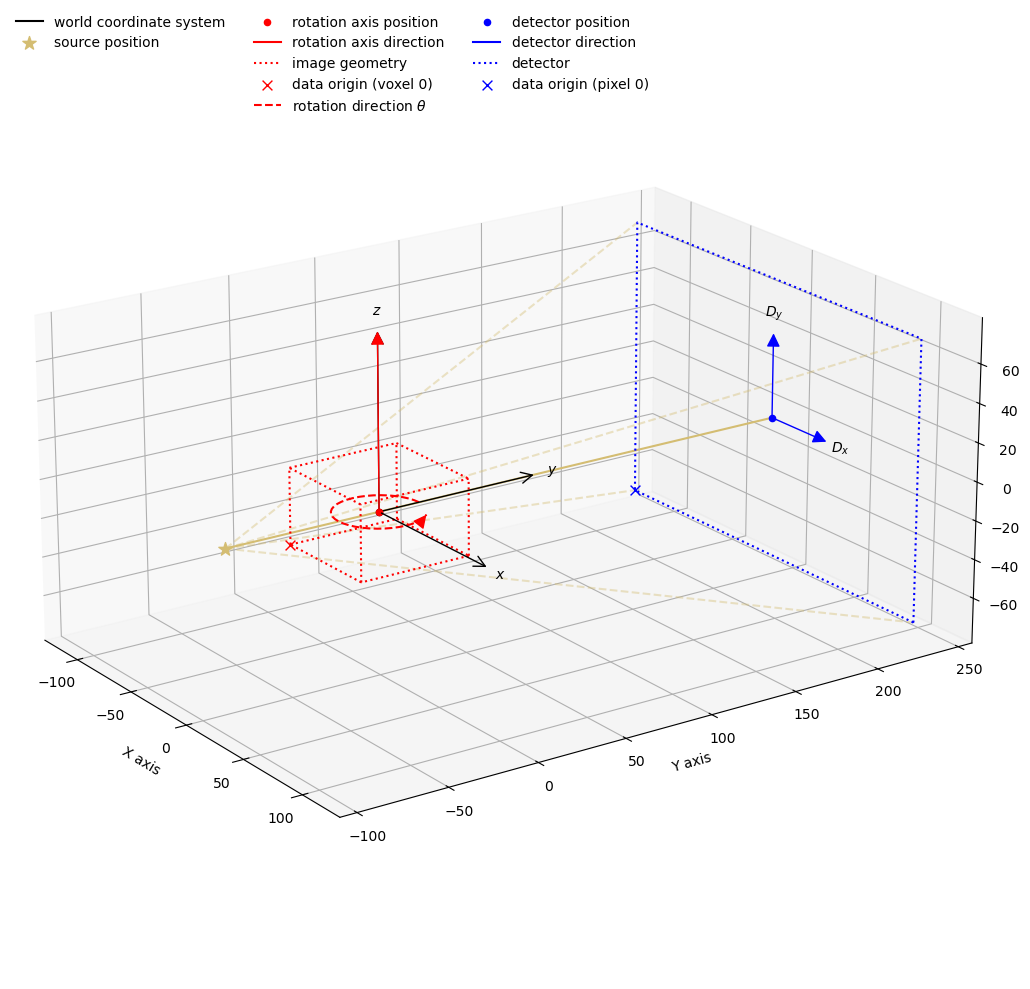

In [6]:
ag = set_geometry(infofile,logfile)
show_geometry(ag,grid=True,view_distance=10,azimuthal=-35)

In [7]:
def get_filelist(datadir,dataset_prefix,num_digits=8):
    return sorted(glob.glob(datadir+'/'+dataset_prefix+('[0-9]' * num_digits)+'.tif'))


In [8]:
filelist = get_filelist(datadir,dataset_prefix)
if len(ag.angles) != len(filelist):
    print('Warning: Number of files does not correspond to number of rotational steps!')

In [9]:
# Modify ROI and data binning if needed
bin = (1,1,1)
roi={'axis_0': (0,ag.num_projections,bin[0]), # angle
     'axis_1': (0,ag.pixel_num_v,bin[1]), # height
     'axis_2': (0,ag.pixel_num_h,bin[2]) # width
    } 

# Create CIL reader
reader = TIFFStackReader(file_name=filelist,roi=roi)


In [10]:
proj = reader.read_as_AcquisitionData(ag)

In [11]:
proj.shape

(901, 1944, 3056)

In [12]:
# Optional: Apply Centre of Rotation Corrector

#processor = CentreOfRotationCorrector.image_sharpness(FBP=tigre.FBP, tolerance=0.1, search_range=30, initial_binning=2) 
#processor.set_input(proj) 
#processor.get_output(out=proj)

In [13]:
# Optional data binning

roi = {'horizontal':(None,None,4),'vertical':(None,None,4)}
processor = Binner(roi)
processor.set_input(proj)
proj = processor.get_output()


In [14]:
# Optional: Ring artefact removal

processor = RingRemover(decNum=4, wname='db10', sigma=1.5, info=True)
processor.set_input(proj)
proj = processor.get_output()

Finish Ring Remover


In [15]:
# Substract Background
background = proj.get_slice(vertical=20, force=True).mean()
proj /= background

In [16]:
# Prepare data for reconstruction

proj = TransmissionAbsorptionConverter(min_intensity=0.000001)(proj)
proj.reorder(order='tigre')
ig = proj.geometry.get_ImageGeometry()


In [17]:
print('Acquisition geometry:\n',ag,end='\n\n')
print('Projection geometry:\n',proj,end='\n\n')
print('Image geometry:\n',ig)

Acquisition geometry:
 3D Cone-beam tomography
System configuration:
	Source position: [  0.   , -85.834,   0.   ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.   , 235.178,   0.   ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [3056 1944]
	Pixel size: [0.0748 0.0748]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 901
	Angles 0-9 in degrees: [0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6]
	Angles 891-900 in degrees: [356.4, 356.8, 357.2, 357.6, 358. , 358.4, 358.8, 359.2, 359.6, 360. ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance

Projection geometry:
 Number of dimensions: 3
Shape: (901, 486, 764)
Axis labels: ('angle', 'vertical', 'horizontal')


Image geometry:
 Number of channels: 1
channel_spacing: 1.0
voxel_num : x764,y7

-0.1060193 3.7856646


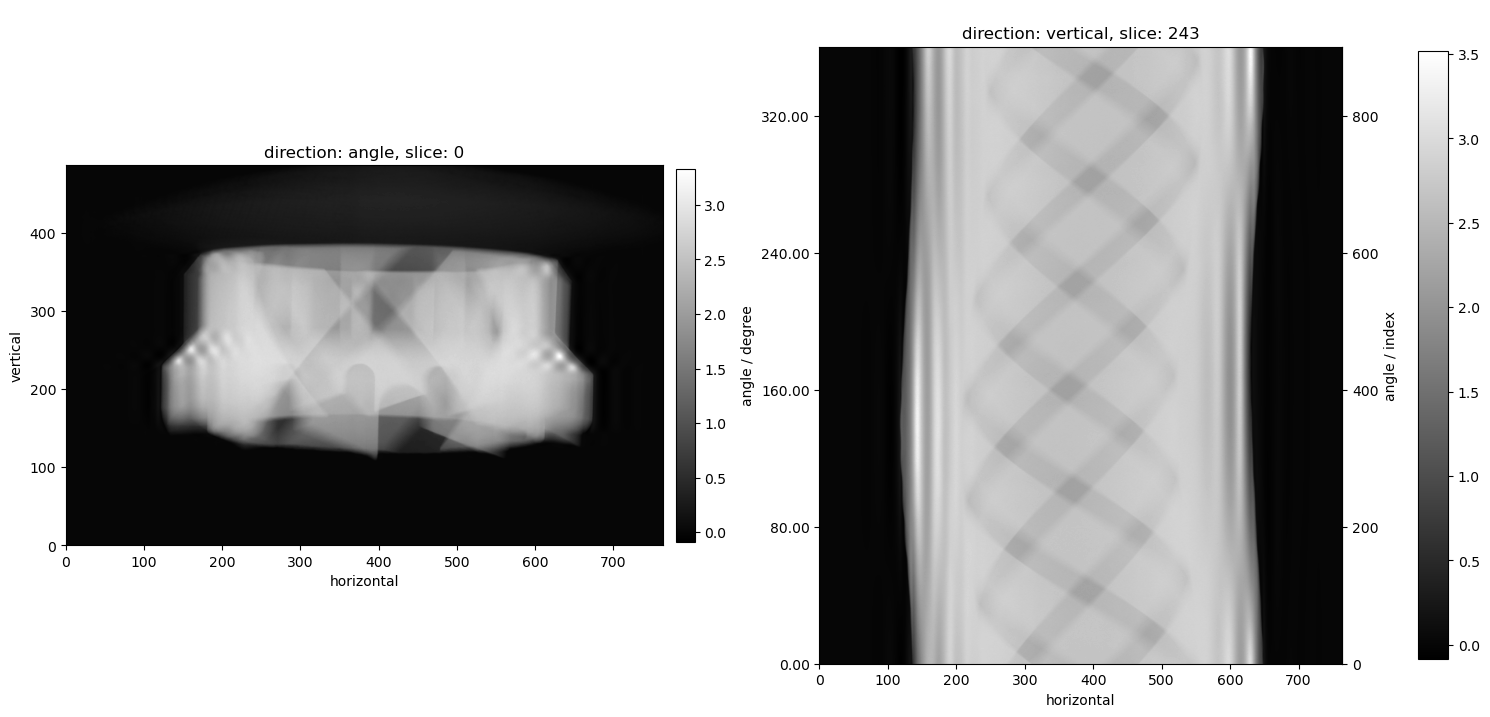

In [18]:
print(proj.min(), proj.max())
show2D(proj, slice_list=[('angle',0),('vertical', np.floor_divide(proj.shape[1],2))])

In [ ]:
# Perform reconstruction

fdk =  FDK(proj, ig)
recon = fdk.run()

FDK recon

Input Data:
	angle: 901
	vertical: 486
	horizontal: 764

Reconstruction Volume:
	vertical: 486
	horizontal_y: 764
	horizontal_x: 764

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



: 

In [ ]:
# Display data
show2D(recon, slice_list=[('horizontal_x', np.floor_divide(ig.shape[2],2)),('horizontal_y', np.floor_divide(ig.shape[1],2)), ('vertical', np.floor_divide(ig.shape[0],2))],fix_range=True)

In [ ]:
# Save data
subfolder = dataset_prefix
#TIFFWriter(data=recon, file_name=os.path.join(path,subfolder,dataset_prefix),compression='uint8').write()